 # Vehicle Routing Problem
 VRP with:
 - Pickups and Deliveries Constraints
 - Time Window Constraints

 ## Imports
 Import all the required libraries

In [1]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from matplotlib import pyplot as plt
import numpy as np

FROM_GOOGLE_MAPS = False

if FROM_GOOGLE_MAPS: 
    from distance_matrix_maps import data
else:
    from distance_matrix_manual import data


 ## Prepade the data
 Create the routing index manager.

In [2]:
locations = np.array(data['locations'])
data['num_vehicles'] = 4
data['depot'] = 0 

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(
    len(data['distance_matrix']),
    data['num_vehicles'], 
    data['depot']
)


 ## Visualize the problem

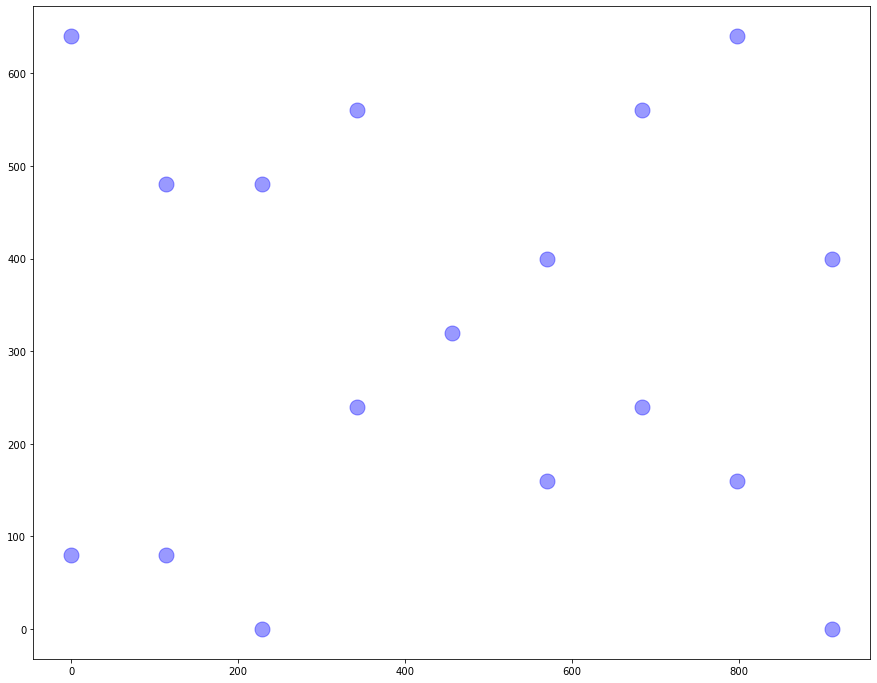

In [3]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.scatter(
    x=locations[:, 0],
    y=locations[:, 1],
    s=15 ** 2,
    c='blue',
    alpha=.4,
    marker='o'
)
plt.show()


 ## Create Routing Model

In [4]:
routing = pywrapcp.RoutingModel(manager)


 ### Create and register a transit callback.

In [5]:
def distance_callback(from_index, to_index):
    """
    Returns the distance between the two nodes.
    """
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)


 ### Define cost of each arc.

In [6]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


 ### Add Distance constraint.

In [7]:
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,      # no slack
    3000,   # vehicle maximum travel distance
    True,   # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

routing


<ortools.constraint_solver.pywrapcp.RoutingModel; proxy of <Swig Object of type 'operations_research::RoutingModel *' at 0x000002293B57D7B0> >

 ## Set first solution to heuristic.

In [8]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters


first_solution_strategy: PATH_CHEAPEST_ARC
local_search_operators {
  use_relocate: BOOL_TRUE
  use_relocate_pair: BOOL_TRUE
  use_relocate_neighbors: BOOL_FALSE
  use_exchange: BOOL_TRUE
  use_cross: BOOL_TRUE
  use_cross_exchange: BOOL_FALSE
  use_two_opt: BOOL_TRUE
  use_or_opt: BOOL_TRUE
  use_lin_kernighan: BOOL_TRUE
  use_tsp_opt: BOOL_FALSE
  use_make_active: BOOL_TRUE
  use_make_inactive: BOOL_TRUE
  use_make_chain_inactive: BOOL_FALSE
  use_swap_active: BOOL_TRUE
  use_extended_swap_active: BOOL_FALSE
  use_path_lns: BOOL_FALSE
  use_full_path_lns: BOOL_FALSE
  use_tsp_lns: BOOL_FALSE
  use_inactive_lns: BOOL_FALSE
  use_node_pair_swap_active: BOOL_TRUE
  use_relocate_and_make_active: BOOL_FALSE
  use_exchange_pair: BOOL_TRUE
  use_relocate_expensive_chain: BOOL_TRUE
  use_light_relocate_pair: BOOL_TRUE
  use_relocate_subtrip: BOOL_TRUE
  use_exchange_subtrip: BOOL_TRUE
  use_global_cheapest_insertion_path_lns: BOOL_TRUE
  use_local_cheapest_insertion_path_lns: BOOL_TRUE
  use

 ## Solve the problem.

In [9]:
solution = routing.SolveWithParameters(search_parameters)


 ## Print the solution

In [10]:
if solution:
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))
else:
    print('No solution found')


Route for vehicle 0:
 0 ->  8 ->  6 ->  2 ->  5 -> 0
Distance of the route: 1552m

Route for vehicle 1:
 0 ->  7 ->  1 ->  4 ->  3 -> 0
Distance of the route: 1552m

Route for vehicle 2:
 0 ->  9 ->  10 ->  16 ->  14 -> 0
Distance of the route: 1552m

Route for vehicle 3:
 0 ->  12 ->  11 ->  15 ->  13 -> 0
Distance of the route: 1552m

Maximum of the route distances: 1552m


 ## Visualize the solution

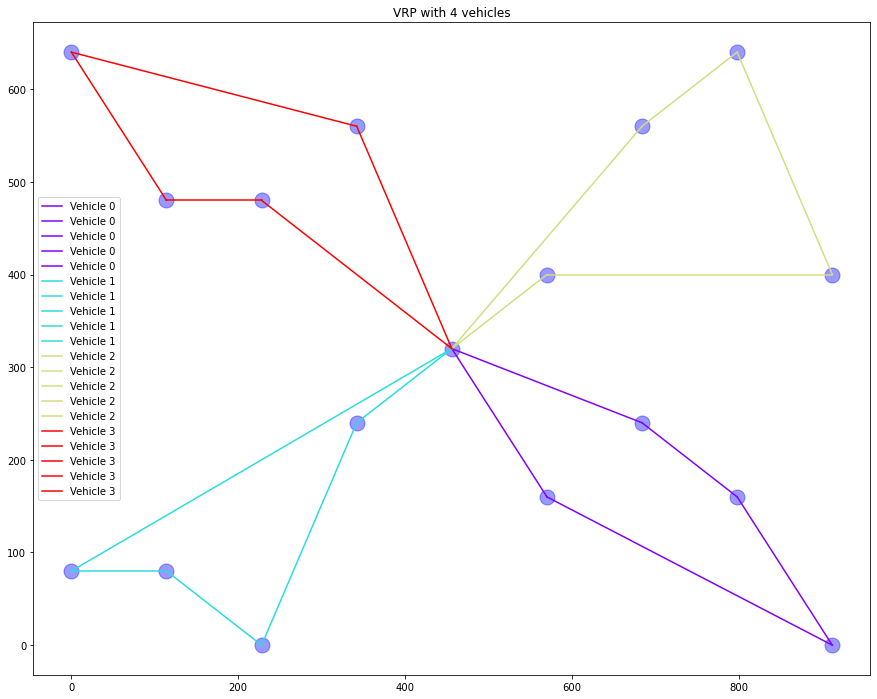

In [11]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.scatter(
    x=locations[:, 0],
    y=locations[:, 1],
    s=15 ** 2,
    c='blue',
    alpha=.4,
    marker='o'
)
colors = plt.cm.rainbow(np.linspace(0, 1, data['num_vehicles']))
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    while not routing.IsEnd(index):
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        line = np.array([
            locations[manager.IndexToNode(previous_index)], 
            locations[manager.IndexToNode(index)]
        ]).T
        ax.plot(
            line[0],
            line[1],
            c=colors[vehicle_id],
            label=f'Vehicle {vehicle_id}'
        )
ax.set_title(f'VRP with {data["num_vehicles"]} vehicles')
ax.legend()
plt.show()
